In [12]:
import os 
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA
# from src.datajoint_config import *

# Generate trial data

In [3]:
dict_path = "/Users/jiayizhang/Documents/code_base/rnn-coach/"
task_name = "ALM"
activation = "relu"
config_dict = json.load(open(os.path.join(dict_path, "data", "configs", f'train_config_{task_name}_{activation}_lambda_orth=0.json'), mode="r"))
print("last updated: ", config_dict["last_compiled"])

last updated:  2023-11-14 17:06:39.008962


In [4]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

# RNN spec
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
if (activation == "relu"):
    activation = lambda x: torch.maximum(x, torch.tensor(0))

In [5]:
# generate data for more trials
n_rights = 100
n_lefts = 100
n_catches = 10 # can't set it to 0
n_trials = n_rights + n_lefts + n_catches
directions = np.zeros(n_trials)

directions[:n_rights] = 1 # right: channel 1
directions[-n_catches:] = -1 # catch: -1
assert(np.sum(directions) == n_rights - n_catches)
print(directions)
directions = directions.astype(int).tolist()
# reset the relevant parameters
task_params['directions'] = directions
task_params['n_rights'] = n_rights
task_params['n_lefts'] = n_lefts
task_params['n_catches'] = n_catches

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [6]:
task = eval("Task" + task_name)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

In [7]:
inputs, targets = task.get_batch()
print(inputs.shape, targets.shape)
n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
n_c = task_params["n_catches"]
channel_names = ["Left", "Right", "Go"]

# for i in range(input_size):  # left, right, go
#     fig = plt.figure(figsize = (10, 2))
#     plt.plot(np.average(inputs[i,:,:n_r], axis=1), c='tab:blue', label="right trials")
#     plt.plot(np.average(inputs[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left trials")
#     plt.plot(np.average(inputs[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch trials")
#     plt.title(f"Input Channle: {channel_names[i]}")
#     plt.legend()

# for i in range(output_size): # left, right
#     fig = plt.figure(figsize = (10, 2))
#     plt.plot(np.average(targets[i,:,:n_r], axis=1), c='tab:blue', label="right trials")
#     plt.plot(np.average(targets[i,:,n_r:n_r+n_l], axis=1), c='tab:red', ls="-.", label="left trials")
#     plt.plot(np.average(targets[i,:,n_r+n_l:n_c+n_r+n_l], axis=1), c='tab:purple', ls="--", label="catch trials")
#     plt.title(f"Output Channle: {channel_names[i]}")
#     plt.legend()

(3, 157, 210) (2, 157, 210)


In [9]:
rnn_name = "trained_RNN_lambda_orth=0_0"
RNN_trained = np.load(os.path.join("../data/trained_RNNs/ALM/","batch_RNNs_0212",f"{rnn_name}.pkl"), allow_pickle=True)

net_params = RNN_trained["net_params"]

# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=np.zeros(net_params["N"]),
                      y_init=net_params["y_init"])

In [10]:
input_batch_valid, target_batch_valid = task.get_batch()

RNN_valid.clear_history()
RNN_valid.run(input_timeseries=input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
output = RNN_valid.get_output()

100 100 10


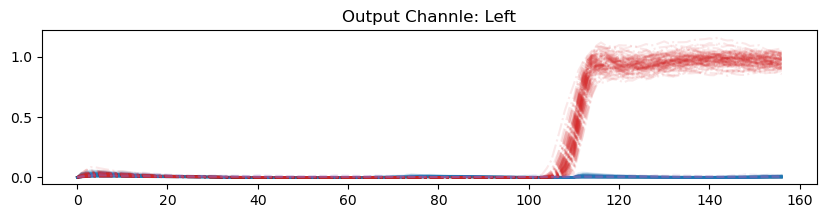

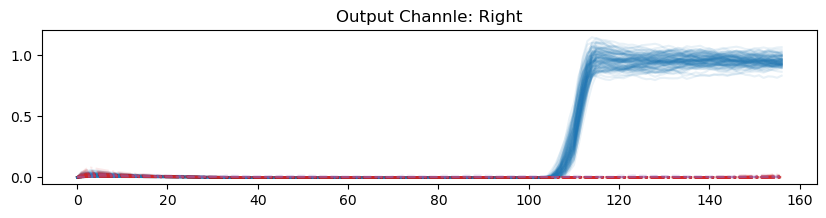

In [11]:
n_r, n_l = task_params["n_rights"], task_params["n_lefts"]
n_c = task_params["n_catches"]
print(n_r, n_l, n_c)
ch_names = ["Left", "Right"]

for i in range(output_size): # left, right
    fig = plt.figure(figsize = (10, 2))
    plt.plot(output[i,:,:n_r], c='tab:blue', alpha=0.1)
    plt.plot(output[i,:,n_r:n_r+n_l], c='tab:red', ls="-.", alpha=0.1)
    plt.plot(output[i,:,n_r+n_l:n_c+n_r+n_l], c='tab:purple', ls="--", alpha=0.1)
    plt.title(f"Output Channle: {ch_names[i]}")

In [124]:
# rnn_trained, train_losses, val_losses, net_params
RNN_valid.clear_history()
RNN_valid.run(input_batch_valid, sigma_inp=sigma_inp, sigma_rec=sigma_rec)
neural_traces = RNN_valid.get_history()
traces_data = {}

traces_data["inputs"] = input_batch_valid
traces_data["targets"] = target_batch_valid
traces_data["traces"] = neural_traces
traces_data["outputs"] = RNN_valid.get_output()
traces_data["net_params"] = net_params

path_to_traces = os.path.join("../data/trained_RNNs/ALM/","test",f"{rnn_name}_{n_trials}trials.pkl")
pickle.dump(traces_data, open(path_to_traces, "wb+"))